# Fractopo – Fracture Network Analysis

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import geopandas as gpd

In [3]:
from fractopo.analysis.network import Network
import matplotlib.pyplot as plt

plt.close()

## Data (KB11)

In [4]:
# Trace and target area data available on GitHub
trace_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_traces.geojson"
area_data_url = "https://raw.githubusercontent.com/nialov/fractopo/master/tests/sample_data/KB11/KB11_area.geojson"

# Use geopandas to load data from urls
traces = gpd.read_file(trace_data_url)
area = gpd.read_file(area_data_url)

# Name the dataset
name = "KB11"

## Visualizing trace map data

<AxesSubplot:>

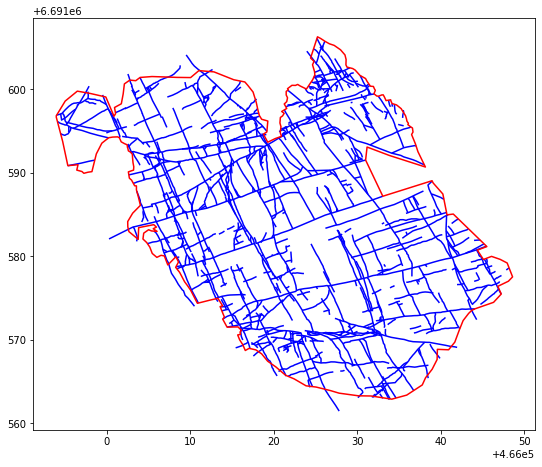

In [5]:
fix, ax = plt.subplots(figsize=(9, 9))
traces.plot(ax=ax, color="blue")
area.boundary.plot(ax=ax, color="red")

## Create Network

In [6]:
# Create Network and automatically determine branches and nodes
kb11_network = Network(traces, area, name=name, determine_branches_nodes=True)

## Visualizing branches and nodes

In [7]:
from fractopo.general import CC_branch, CI_branch, II_branch, X_node, Y_node, I_node

# Function to determine color for each branch and node type
def assign_colors(feature_type: str):
    if feature_type in (CC_branch, X_node):
        return "green"
    if feature_type in (CI_branch, Y_node):
        return "blue"
    if feature_type in (II_branch, I_node):
        return "black"
    return "red"

| Branch or Node Type | Color |
|---------------------|-------|
| C - C, X            | Green |
| C - I, Y            | Blue  |
| I - I, I            | Black |
| Other               | Red   |

### Branches

<AxesSubplot:>

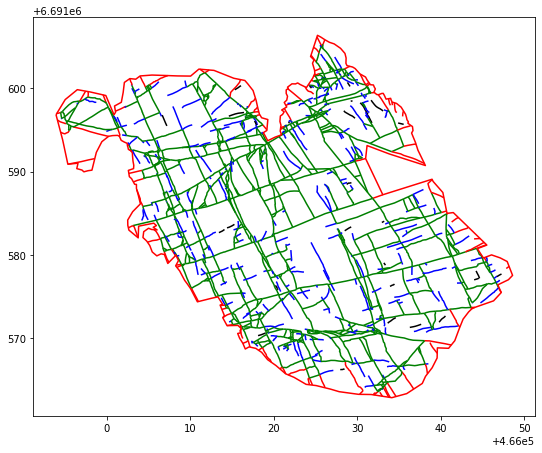

In [8]:
fix, ax = plt.subplots(figsize=(9, 9))
kb11_network.branch_gdf.plot(
    colors=[assign_colors(bt) for bt in kb11_network.branch_types], ax=ax
)
area.boundary.plot(ax=ax, color="red")

### Nodes

<AxesSubplot:>

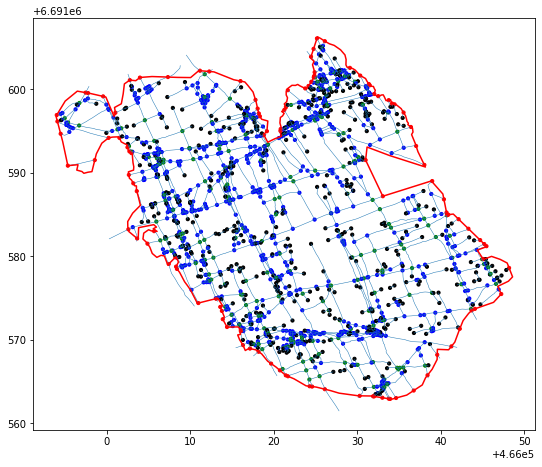

In [9]:
fix, ax = plt.subplots(figsize=(9, 9))
# Traces
kb11_network.trace_gdf.plot(ax=ax, linewidth=0.5)
# Nodes
kb11_network.node_gdf.plot(
    c=[assign_colors(bt) for bt in kb11_network.node_types], ax=ax, markersize=10
)
area.boundary.plot(ax=ax, color="red")

## Rose plots

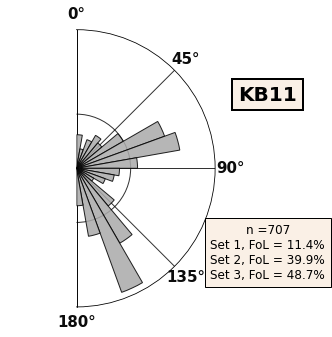

In [10]:
# Plot azimuth rose plot of fracture traces
azimuth_bin_dict, fig, ax = kb11_network.plot_trace_azimuth()

## Length distributions

Calculating best minimal value for power law fit


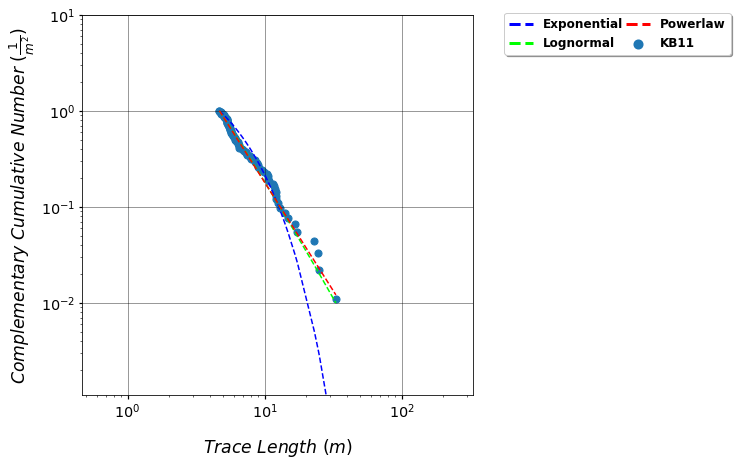

In [11]:
# Plot length distribution fits (powerlaw, exponential and lognormal) of fracture traces
fit, fig, ax = kb11_network.plot_trace_lengths()

In [12]:
# Fit properties
print(f"Automatically determined powerlaw cut-off: {fit.xmin}")
print(f"Powerlaw exponent: {fit.alpha - 1}")
print(
    f"Compare powerlaw fit to lognormal: R, p = {fit.distribution_compare('power_law', 'lognormal')}"
)

Automatically determined powerlaw cut-off: 4.677907783545403
Powerlaw exponent: 2.2575260213182795
Compare powerlaw fit to lognormal: R, p = (-0.04942734072904509, 0.8230966119433478)


## Crosscutting and abutting relationships

In [13]:
# Sets are defaults
print(f"Azimuth set names: {kb11_network.azimuth_set_names}")
print(f"Azimuth set ranges: {kb11_network.azimuth_set_ranges}")

Azimuth set names: ('1', '2', '3')
Azimuth set ranges: ((0, 60), (60, 120), (120, 180))


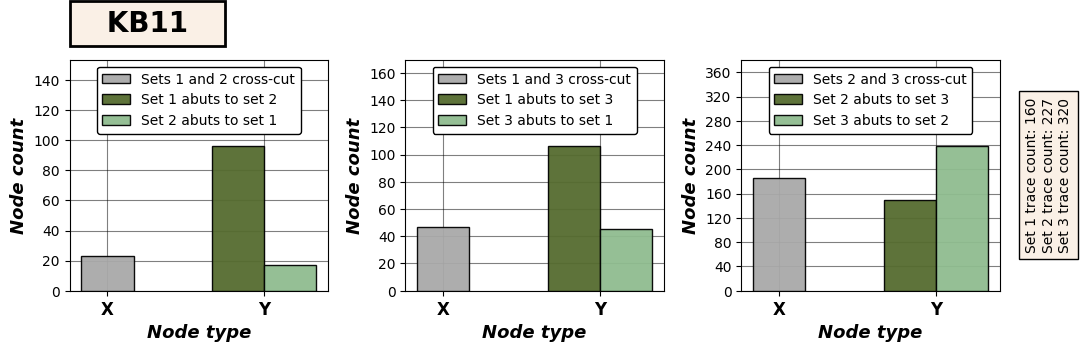

In [14]:
# Plot crosscutting and abutting relationships between azimuth sets
figs, fig_axes = kb11_network.plot_azimuth_crosscut_abutting_relationships()

## Node and branch proportions

In [15]:
kb11_network.node_counts

{'X': 270, 'Y': 825, 'I': 477, 'E': 114}

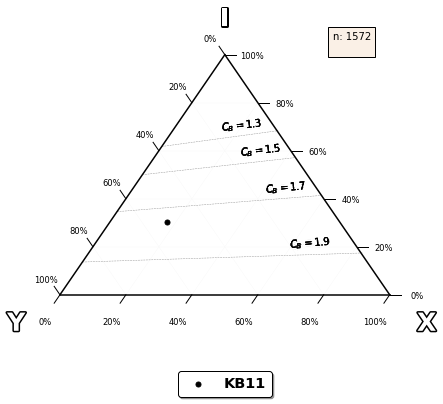

In [16]:
# Plot ternary XYI-node proportion plot
fig, ax, tax = kb11_network.plot_xyi()

In [17]:
kb11_network.branch_counts

{'C - C': 1525, 'C - I': 405, 'I - I': 30}

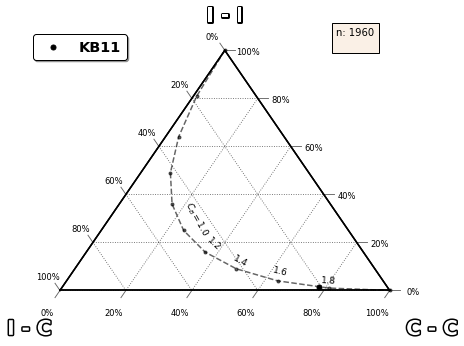

In [18]:
# Plot ternary branch (C-C, C-I, I-I) proportion plot
fig, ax, tax = kb11_network.plot_branch()